# Deploy model and run inference

In [7]:
%%capture
%pip install sagemaker -U

In [8]:
import os
import glob
import cv2
import sagemaker
from sagemaker.tensorflow import TensorFlowModel
from sagemaker.utils import name_from_base
%matplotlib inline
import matplotlib.pyplot as plt
import visualization_utils as viz_utils

In [9]:
role = sagemaker.get_execution_role()

Now that you have trained successfully your model, you want to look at the predictions on some sample images. To do so, you will need to find the s3 path of the exported model. You can navigate to the Training jobs section of the AWS web UI and click on the training job of interest. Scroll down and you should see something like this:

![Example Artifact](../data/example_artifact.png)

The model artifact path should look something like 
```s3://sagemaker-us-east-1-073338978050/tf2-object-detection-2022-10-22-21-26-37-033/output/model.tar.gz```. Use this value to update the `model_artifact` variable below.

In [10]:
# TODO: Update the model artifact here. 
model_artifact = 's3://sagemaker-us-east-1-919802314564/tf2-object-detection-2024-07-22-17-45-54-278/output/model.tar.gz'

Now we can deploy the model. Run the following cell and check that the model was correctly deployed by navigating to Inference endpoints in the web UI.

![Example endpoint](../data/example_endpoints.png)


In [11]:
model = TensorFlowModel(
    name=name_from_base('tf2-object-detection'),
    model_data=model_artifact,
    role=role,
    framework_version='2.8'
)

predictor = model.deploy(initial_instance_count=1, instance_type='ml.g5.xlarge')

-------------!

## Run inference

Our model is now deployed and we can query it. We are going to use the images available in `data/test_video` to run inference and generate a video. To do so, we are going to need a few tools:
* we need to sort all the frames by index order (which corresponds to chronological order)
* we need a function to load images into numpy array
* we need a loop to run inference and display the results on the input image

We list the frame paths and sort them by index.

In [12]:
frames_path = sorted(glob.glob('../data/test_video/*.png'), 
                     key = lambda k: int(os.path.basename(k).split('.')[0].split('_')[1]))

We create a small function to load images.

In [13]:
import numpy as np
def load_image(path: str) -> np.ndarray:
    """Read an image from the path and returns a numpy array"""
    cv_img = cv2.imread(path,1).astype('uint8')
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return cv_img

We create a mapping from id to name for visualization purposes.

In [14]:
category_index = {
                    1: {'id': 1, 'name': 'vehicle'}, 
                    2: {'id': 2, 'name': 'pedestrian'},
                    4: {'id': 4, 'name': 'cyclist'}
                }

This is the main loop:
* we load images to numpy
* we query the deployed model
* we display the inference results on the images

In [15]:
def image_file_to_tensor(path):
    cv_img = cv2.imread(path,1).astype('uint8')
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return cv_img

images = []
for idx, path in enumerate(frames_path):
    if idx % 10 == 0:
        print(f'Processed {idx}/{len(frames_path)} images.')
        
    # load image
    img = image_file_to_tensor(path)
    inputs = {'instances': [img.tolist()]}
    
    # run inference and extract results
    detections = predictor.predict(inputs)['predictions'][0]
    detection_boxes = np.array(detections['detection_boxes'])
    detection_classes = [int(x) for x in detections['detection_classes']]
    detection_scores = detections['detection_scores']
    
    # display results on image
    image_np_with_detections = \
        viz_utils.visualize_boxes_and_labels_on_image_array(
            img,
            detection_boxes,
            detection_classes,
            detection_scores,
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=100,
            min_score_thresh=0.6,
            agnostic_mode=False)
    images.append(image_np_with_detections)

Processed 0/100 images.
Processed 10/100 images.
Processed 20/100 images.
Processed 30/100 images.
Processed 40/100 images.
Processed 50/100 images.
Processed 60/100 images.
Processed 70/100 images.
Processed 80/100 images.
Processed 90/100 images.


We can verify that the model worked correctly by displaying elements of the `images` list.

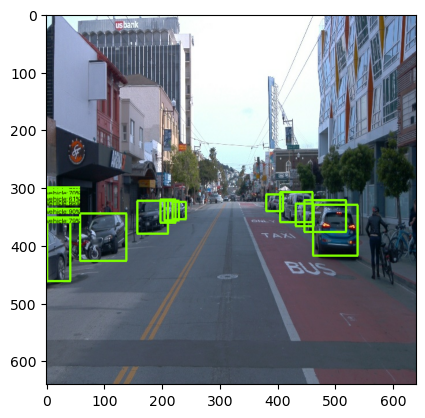

In [16]:
plt.imshow(images[0])

Finally, we can create a video (`output.avi`) with our detections by running the following function.

In [18]:
frame_width = images[0].shape[0]
frame_height = images[0].shape[1]

out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

# Read and display the images
for image in images:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    out.write(image) # Write the image to the video
    if cv2.waitKey(1) == ord('q'): # Hit `q` to exit
        break
        
# Release everything if job is finished
out.release()
cv2.destroyAllWindows()

The video would be stored in the current working directory. You can download it from Sagemaker and run it locally.